<a href="https://colab.research.google.com/github/vischia/lisbon-ml-school/blob/master/dataChallenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lisbon Machine Learning School
## Data Challenge!!! Multitarget regression

(C) Pietro Vischia (Universidad de Oviedo and ICTEA), pietro.vischia@cern.ch


## Setup the environment

- If you are running locally, you don't need to run anything

- If you are running on Google Colab, uncomment and run the next cell (remove only the "#", keep the "!"). You can also run it from a local installation, but it will do nothing if you have already installed all dependencies (and it will take some time to tell you it is not gonna do anything).

## Load the needed libraries

In [267]:
import os

import torch
import torch.nn as nn  
import torch.optim as optim 
from torch.utils.data import Dataset, DataLoader 
import torch.nn.functional as F 
import torchvision
import torchinfo
from tqdm import tqdm

import sklearn
import sklearn.model_selection
from sklearn.metrics import roc_curve, auc, accuracy_score

import uproot

import pandas as pd

import matplotlib
matplotlib.rcParams['figure.figsize'] = (8, 6)
matplotlib.rcParams['axes.labelsize'] = 14
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.backends.mps.is_available():
    device = torch.device("mps")
    torch.set_default_dtype(torch.float32)

print('Using torch version', torch.__version__)
print('Using device:', device)


Using torch version 2.6.0
Using device: mps


## Load the data

We will use the same data we used for exercise 2, that is simulated events corresponding to three physics processes.
- ttH production
- ttW production
- Drell-Yan ($pp\\to Z/\\gamma^*$+jets) production

We will select the multilepton final state, which is a challenging final state with a rich structure and nontrivial background separation.

<img src="figs/2lss.png" alt="ttH multilepton 2lss" style="width:40%"/>

We use the [uproot](https://uproot.readthedocs.io/en/latest/basic.html) library to conveniently read in a [ROOT TNuple](https://root.cern.ch/doc/master/classTNtuple.html) which can automatically convert it to a [pandas dataframe](https://pandas.pydata.org/).

In [268]:
# # Download the data only if you haven't done so yet

# if not os.path.isfile("data/signal_blind20.root"): 
#     !mkdir data; cd data/; wget https://www.hep.uniovi.es/vischia/lisbon_ml_school/lisbon_ml_school_tth.tar.gz; tar xzvf lisbon_ml_school_tth.tar.gz; rm lisbon_ml_school_tth.tar.gz; cd -;


In [269]:

data = uproot.open('data/signal_blind20.root')['Friends'].arrays(library="pd")



## Data Inspection

Select the features you want to use for this exercise, don't forget to remove unnecessary features.

Most of the variables are input features, corresponding to detector measurements of the properties of the reconstructed decay products.

There are three special variables, though:

- `Hreco_evt_tag`: this feature has values in ${0,1}$, where $1$ flags the event as signal event, and $0$ flags the event as background event;
- `Hreco_HTXS_Higgs_pt`: this feature contains the true generate Higgs boson transverse momentum at generator level (used for regression);
- `Hreco_HTXS_Higgs_y`: this feature contains the true generated Higgs boson rapidity (not pseudorapidity) at generator level (used for regression).


### Important

Twenty percent of the events have `-99` in the `Hreco_HTXS_Higgs_pt` and `Hreco_HTXS_Higgs_y` values. These are the "unlabelled" events that you will have to send predictions for. You should filter them out for training and testing

## The assignment

- For this data challenge, your target is to simultaneously regress the Higgs transverse momentum `Hreco_HTXS_Higgs_pt` and the rapidity `Hreco_HTXS_Higgs_y`

- You will need to split your dataset into two parts: one is where you have access to the pT and y labels (80% of the dataset): you will build your training and test sets from this. The other is where the pT and y has been set to -99: this is the portion of data that is kept blind. You will have to use 80% of the data to train a regressor, then evaluate the output of your regressor on the blind 20% of the data, and send us the results. We will compare the result with the true value we have.

In [270]:
# Drop unneeded features

blind_data = data[data["Hreco_HTXS_Higgs_pt"]==-99]

train_val_data = data[data["Hreco_HTXS_Higgs_pt"]!=-99]
train_val_data = train_val_data[data["Hreco_Lep2_pt"]!=-99]
train_val_data = train_val_data[data["Hreco_HTXS_Higgs_y"]>=0]

print(blind_data.shape[0] / data.shape[0])
print(train_val_data.shape[0] / data.shape[0])



train_val_labels = train_val_data[["Hreco_HTXS_Higgs_pt", "Hreco_HTXS_Higgs_y"]].copy()

train_val_data = train_val_data.drop(["index", "Hreco_HTXS_Higgs_pt", "Hreco_Lep2_phi", "Hreco_Lep2_mass", "Hreco_Lep2_eta", "Hreco_Lep2_pt" , "Hreco_HTXS_Higgs_y", "Hreco_evt_tag"], axis=1 )
blind_data_features = blind_data.drop(["index", "Hreco_HTXS_Higgs_pt", "Hreco_Lep2_phi", "Hreco_Lep2_mass", "Hreco_Lep2_eta", "Hreco_Lep2_pt" , "Hreco_HTXS_Higgs_y", "Hreco_evt_tag"], axis=1 )

# Filter data
print(train_val_data.columns)
print(train_val_labels.columns)

from sklearn.preprocessing import StandardScaler# standard scaling
train_data, val_data, train_labels, val_labels = sklearn.model_selection.train_test_split(train_val_data, train_val_labels, test_size=0.1, random_state=42)

# Scale the train input features
for column in train_data.columns:
    scaler_train = StandardScaler().fit(train_data.filter([column], axis=1))
    train_data[column] = scaler_train.transform(train_data.filter([column], axis=1))

for column in val_data.columns:
    scaler_val = StandardScaler().fit(val_data.filter([column], axis=1))
    val_data[column] = scaler_val.transform(val_data.filter([column], axis=1))

for column in blind_data_features.columns:
    scaler_blind = StandardScaler().fit(blind_data_features.filter([column], axis=1))
    blind_data_features[column] = scaler_blind.transform(blind_data_features.filter([column], axis=1))


# Scale the labels
for column in train_labels.columns:
    scaler_train_label = StandardScaler().fit(train_labels.filter([column], axis=1))
    train_labels[column] = scaler_train_label.transform(train_labels.filter([column], axis=1))

for column in val_labels.columns:
    scaler_val_label = StandardScaler().fit(val_labels.filter([column], axis=1))
    val_labels[column] = scaler_val_label.transform(val_labels.filter([column], axis=1))


0.19994854437379506
0.12417178160093822
Index(['Hreco_Lep0_pt', 'Hreco_Lep1_pt', 'Hreco_HadTop_pt',
       'Hreco_All5_Jets_pt', 'Hreco_More5_Jets_pt', 'Hreco_Jets_plus_Lep_pt',
       'Hreco_Lep0_eta', 'Hreco_Lep1_eta', 'Hreco_HadTop_eta',
       'Hreco_All5_Jets_eta', 'Hreco_More5_Jets_eta',
       'Hreco_Jets_plus_Lep_eta', 'Hreco_Lep0_phi', 'Hreco_Lep1_phi',
       'Hreco_HadTop_phi', 'Hreco_All5_Jets_phi', 'Hreco_More5_Jets_phi',
       'Hreco_Jets_plus_Lep_phi', 'Hreco_Lep0_mass', 'Hreco_Lep1_mass',
       'Hreco_HadTop_mass', 'Hreco_All5_Jets_mass', 'Hreco_More5_Jets_mass',
       'Hreco_Jets_plus_Lep_mass', 'Hreco_TopScore', 'Hreco_met',
       'Hreco_met_phi'],
      dtype='object')
Index(['Hreco_HTXS_Higgs_pt', 'Hreco_HTXS_Higgs_y'], dtype='object')


/var/folders/hn/0x08jk9154vfvmkr47q5hvc40000gn/T/ipykernel_20429/197265847.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  train_val_data = train_val_data[data["Hreco_Lep2_pt"]!=-99]
/var/folders/hn/0x08jk9154vfvmkr47q5hvc40000gn/T/ipykernel_20429/197265847.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  train_val_data = train_val_data[data["Hreco_HTXS_Higgs_y"]>=0]


- The loss function typically used for regression problems is the mean square error: in this case you will have to figure out how to deal with the fact that the output vector has dimension two (transverse momentum, and rapidity).
- A tricky challenge is to deal with output features that have different scales: the rapidity is of $\mathcal{O}(1)$, the transverse momentum is of $\\mathcal{O}(100-1000}$

## Regression problems

Regression problems require the prediction to be free of adopting the same range as the target variable(s) that need to be regressed.

This is why the sigmoid activation function is not a good choice. The typical form of output layers of a regression problem is, if `n_outputs` is the dimension of the output vector:


In [271]:
class MyDataset(Dataset):
    def __init__(self, X, y, device=torch.device("cpu")):
        self.X = torch.Tensor(X.values).to(device)
        self.y = torch.Tensor(y.values).to(device)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        label = self.y[idx]
        datum = self.X[idx]
        
        return datum, label

batch_size=1024 # Minibatch learning


train_dataset = MyDataset(train_data, train_labels)
val_dataset = MyDataset(val_data, val_labels)


train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
true_test_dataloader = DataLoader(blind_data_features, batch_size=1, shuffle=False)

train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")


Feature batch shape: torch.Size([1024, 27])
Labels batch shape: torch.Size([1024, 2])


In [272]:
class NeuralNetwork(nn.Module):
    def __init__(self, ninputs, device=torch.device("cpu")):
        super().__init__()
        self.device = device
        
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(ninputs, 1024),
            nn.LeakyReLU(),
            nn.Linear(1024, 512),
            nn.LeakyReLU(),
            nn.Linear(512, 128),
            nn.LeakyReLU(),
            nn.Linear(128,64),
            nn.LeakyReLU(),
            nn.Linear(64,8),
            nn.LeakyReLU(),
            nn.Linear(8, 2),
        )
        self.linear_relu_stack.to(device)

    def forward(self, x):
        # Pass data through conv1
        x = self.linear_relu_stack(x)
        return x

model = NeuralNetwork(train_data.shape[1])

print(model) # some basic info

print("Now let's see some more detailed info by using the torchinfo package")
torchinfo.summary(model, input_size=(batch_size, train_data.shape[1])) # the input size is (batch size, number of features)

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=27, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=512, out_features=128, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): LeakyReLU(negative_slope=0.01)
    (8): Linear(in_features=64, out_features=8, bias=True)
    (9): LeakyReLU(negative_slope=0.01)
    (10): Linear(in_features=8, out_features=2, bias=True)
  )
)
Now let's see some more detailed info by using the torchinfo package


Layer (type:depth-idx)                   Output Shape              Param #
NeuralNetwork                            [1024, 2]                 --
├─Sequential: 1-1                        [1024, 2]                 --
│    └─Linear: 2-1                       [1024, 1024]              28,672
│    └─LeakyReLU: 2-2                    [1024, 1024]              --
│    └─Linear: 2-3                       [1024, 512]               524,800
│    └─LeakyReLU: 2-4                    [1024, 512]               --
│    └─Linear: 2-5                       [1024, 128]               65,664
│    └─LeakyReLU: 2-6                    [1024, 128]               --
│    └─Linear: 2-7                       [1024, 64]                8,256
│    └─LeakyReLU: 2-8                    [1024, 64]                --
│    └─Linear: 2-9                       [1024, 8]                 520
│    └─LeakyReLU: 2-10                   [1024, 8]                 --
│    └─Linear: 2-11                      [1024, 2]                 1

The other big change with respect to classification models is that the cross-entropy is not the proper loss function anymore.

The regression problem is essentially a generalization of a linear regression problem, and the typical error estimates from classical statistics apply, each with its pros and cons.

#### Mean Absolute Error (MAE)

$MAE(\hat{y}, y^{*}) = \frac{1}{N} \sum |\hat{y} - y^{*}|$

- Lower values are better.
- It estimates the average error, thus cannot distinguish between one large error and many small errors.

#### Root Mean Squared Error (RMSE)

$RMSE(\hat{y}, y^{*}) = \sqrt{\sum \frac{(\hat{y} - y^{*})^2}{N}}$

- Lower values are better.
- It estimates the spread of the residuals (standard deviation of the unexplained variance)
- It gives large weight to large errors (if you use it as loss function, it will prioritize the reduction of large errors)

#### Mean Absolute Percentage Error (MAPE)

$MAPE(\hat{y}, y^{*}) = \frac{100\%}{N} \sum \Big|\frac{\hat{y} - y^{*}}{y^{*}}\Big|$

#### R-Squared Score

$R^2(\hat{y}, y^{*}) = 1-\frac{ \sum (\hat{y} - y^{*})^2}{  \sum(\bar{y} - y^{*})^2  }$, 

where $\bar{y}$ is the arithmetic mean of the true values, $\bar{y} = \frac{1}{N}\sum_{i=0}^{N-1} y^{*}$

- It estimates how well the model explains the variance of the data
- It can be negative (and that means that the model fits badly the data)


You can consult online [an overview of the available loss functions in `pytorch`](https://pytorch.org/docs/stable/nn.html#loss-functions).


## A few hints

- Remove useless features
- Consider the possibility of applying preprocessing to the input features, to the target features, or to both
- Choose the appropriate metric to track
- You can recycle the code for DataSet, DataLoader, Neural Network model, and train/test loops from exercise_1 essentially verbatim. Just make sure you change the loss function, and you change the output activation function to `nnReLU()`
- Loss functions can be made as complicated as you want by defining your own loss function, e.g.:

In [273]:
loss_fn = nn.MSELoss()

## The scoring system

- You will have to define a model with two output nodes: the first one must regress the Higgs boson transverse momentum, the second one must regress the Higgs boson rapidity.
- You can also use any flavour of boosted decision trees you may see fit, but implemented in `torch`.
- You will have to evaluate your model on the unlabelled data, save the predictions to a csv file with commas as separators (format: pt, y), and send us the csv file (see below). 
- If you have filtered the features further, please include in the email the code that creates the `data` dataframe.

We will evaluate the results of the challenge on the unlabelled events, using as performance metric the RMSE.


In [274]:
def train_loop(dataloader, model, loss_fn, optimizer, scheduler, best_model_path, device):
    size = len(dataloader.dataset)
    losses=[] # Track the loss function
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    #for batch, (X, y) in enumerate(dataloader):
    best_loss = np.inf
    for (X,y) in tqdm(dataloader):
        # Reset gradients (to avoid their accumulation)
        optimizer.zero_grad()
        # Compute prediction and loss
        pred = model(X)
        #if (all_equal3(pred.detach().numpy())):
        #    print("All equal!")
        loss = loss_fn(pred.squeeze(dim=1), y)
        losses.append(loss.detach().cpu())
        if loss < best_loss:
            best_loss = loss.detach().cpu()
            torch.save(model.state_dict(), best_model_path) # Save the full state of the model, to have access to the training history
        # Backpropagation
        loss.backward()
        optimizer.step()

    scheduler.step()
    return np.mean(losses)

In [275]:
def test_loop(dataloader, model, loss_fn, device):
    losses=[] # Track the loss function
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        #for X, y in dataloader:
        for (X,y) in tqdm(dataloader):
            pred = model(X)
            loss = loss_fn(pred.squeeze(dim=1), y).item()
            losses.append(loss)
            test_loss += loss
            #correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            
    return np.mean(losses)

In [276]:
epochs=20
learningRate = 0.001

# The optimizer decides which path to follow through the gradient of the loss function
optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
# The scheduler reduces the learning rate for the optimizer in order to for the optimizer to be able to "enter" narrow minima
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 100, gamma=0.9)

train_losses=[]
test_losses=[]
best_model_path = "best_dnn_model.h5"
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss=train_loop(train_dataloader, model, loss_fn, optimizer, scheduler, best_model_path, device)
    test_loss=test_loop(test_dataloader, model, loss_fn, device)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    # print("Avg train loss", train_loss, ", Current learning rate", scheduler.get_last_lr())
    print("Avg train loss", train_loss, ", Avg test loss", test_loss, "Current learning rate", scheduler.get_last_lr())
print("Done!")

Epoch 1
-------------------------------


100%|██████████| 4/4 [00:00<00:00, 153.59it/s]


Avg train loss 0.7147305 , Avg test loss 0.625984326004982 Current learning rate [0.001]
Epoch 2
-------------------------------


100%|██████████| 4/4 [00:00<00:00, 148.02it/s]


Avg train loss 0.6239772 , Avg test loss 0.6145319193601608 Current learning rate [0.001]
Epoch 3
-------------------------------


100%|██████████| 4/4 [00:00<00:00, 156.44it/s]


Avg train loss 0.6158557 , Avg test loss 0.6060621589422226 Current learning rate [0.001]
Epoch 4
-------------------------------


100%|██████████| 4/4 [00:00<00:00, 129.20it/s]


Avg train loss 0.6063636 , Avg test loss 0.599437415599823 Current learning rate [0.001]
Epoch 5
-------------------------------


100%|██████████| 4/4 [00:00<00:00, 134.45it/s]


Avg train loss 0.59759843 , Avg test loss 0.6068914085626602 Current learning rate [0.001]
Epoch 6
-------------------------------


100%|██████████| 4/4 [00:00<00:00, 124.53it/s]


Avg train loss 0.59259087 , Avg test loss 0.5954073518514633 Current learning rate [0.001]
Epoch 7
-------------------------------


100%|██████████| 4/4 [00:00<00:00, 151.23it/s]


Avg train loss 0.5878826 , Avg test loss 0.5920240432024002 Current learning rate [0.001]
Epoch 8
-------------------------------


100%|██████████| 4/4 [00:00<00:00, 144.08it/s]


Avg train loss 0.5856148 , Avg test loss 0.6061148196458817 Current learning rate [0.001]
Epoch 9
-------------------------------


100%|██████████| 4/4 [00:00<00:00, 141.11it/s]


Avg train loss 0.58207965 , Avg test loss 0.5905646085739136 Current learning rate [0.001]
Epoch 10
-------------------------------


100%|██████████| 4/4 [00:00<00:00, 142.09it/s]


Avg train loss 0.57569236 , Avg test loss 0.599505603313446 Current learning rate [0.001]
Epoch 11
-------------------------------


100%|██████████| 4/4 [00:00<00:00, 137.01it/s]


Avg train loss 0.5746459 , Avg test loss 0.5945260226726532 Current learning rate [0.001]
Epoch 12
-------------------------------


100%|██████████| 4/4 [00:00<00:00, 146.47it/s]


Avg train loss 0.56407917 , Avg test loss 0.601356714963913 Current learning rate [0.001]
Epoch 13
-------------------------------


100%|██████████| 4/4 [00:00<00:00, 130.24it/s]


Avg train loss 0.56415707 , Avg test loss 0.6012185513973236 Current learning rate [0.001]
Epoch 14
-------------------------------


100%|██████████| 4/4 [00:00<00:00, 150.73it/s]


Avg train loss 0.5576741 , Avg test loss 0.607116237282753 Current learning rate [0.001]
Epoch 15
-------------------------------


100%|██████████| 4/4 [00:00<00:00, 148.73it/s]


Avg train loss 0.55338293 , Avg test loss 0.5982401818037033 Current learning rate [0.001]
Epoch 16
-------------------------------


100%|██████████| 4/4 [00:00<00:00, 142.49it/s]


Avg train loss 0.5460128 , Avg test loss 0.6083840131759644 Current learning rate [0.001]
Epoch 17
-------------------------------


100%|██████████| 4/4 [00:00<00:00, 119.57it/s]


Avg train loss 0.5426626 , Avg test loss 0.5972598195075989 Current learning rate [0.001]
Epoch 18
-------------------------------


100%|██████████| 4/4 [00:00<00:00, 141.89it/s]


Avg train loss 0.5411463 , Avg test loss 0.6032215803861618 Current learning rate [0.001]
Epoch 19
-------------------------------


100%|██████████| 4/4 [00:00<00:00, 142.04it/s]


Avg train loss 0.52751267 , Avg test loss 0.6029143184423447 Current learning rate [0.001]
Epoch 20
-------------------------------


100%|██████████| 4/4 [00:00<00:00, 145.82it/s]

Avg train loss 0.52165693 , Avg test loss 0.6000750213861465 Current learning rate [0.001]
Done!


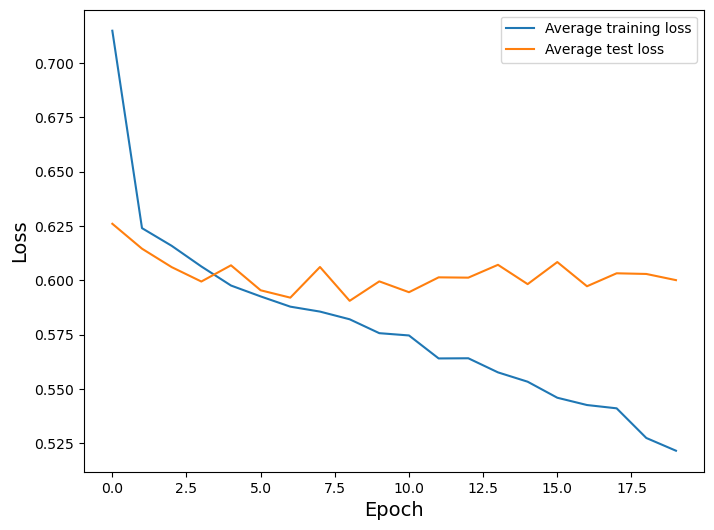

In [277]:
plt.figure()
plt.plot(train_losses, label="Average training loss")
plt.plot(test_losses, label="Average test loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="best")
plt.show()
plt.close()

In [ ]:
pred=model(torch.tensor(blind_data_features.to_numpy()))
to_send = pred.cpu().detach().numpy()
df_to_send = pd.DataFrame(to_send)

for column in df_to_send.columns:
    df_to_send[column] = scaler_train_label.inverse_transform(df_to_send.filter([column], axis=1))

df_to_send.to_csv("my_file_group_4",index=False) # Replace "N" with the group number we assigned you


# Practical instructions

- Divide yourselves in groups of three. Once the groups are defined, we will assign you a numerical label.
- Each group will have to send the csv file mentioned above as an attached `.csv`file to [lisbon-ml-workshop@cern.ch](mailto:lisbon-ml-workshop@cern.ch). The email (ONE EMAIL PER GROUP) must have:
  - As an object: "LIP ML Workshop Data Challenge: Group N", where "N" is the number we assigned you above
  - All the three members of the group must be in carbon copy to the email
  - In the email text there must be a list of the full names of the three members of the project